In [1]:
%load_ext autoreload
%autoreload 2

In [86]:
import pandas as pd
from preprocessing import load_if_in_country_or_lang
from preprocessing import categorize_views_for_df
from processing import filter_by_region_cat_code, build_regression_dataframe, load_preprocessed_events
from plot_regression import plot_regression_results_from_dict, plot_regression_results_interactions_from_dict, plot_cat_by_cat_variable
import numpy as np
from regression import fit_nb_with_estimated_alpha, estimate_alpha, fit_nb, standardize_var, fit_nb_with_estimated_alpha_all_codes, standardize_var

In [3]:
df_crawled = pd.read_csv('events/new/processed_0_manually_with_wikiviews.csv').drop_duplicates()

In [4]:
df_crawled[df_crawled.cat == 'undefined'].head()

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,in_code_lang,in_code_region,date_month,views_baseline,view_country_article
200,Q107353229,Chinese elephants expedition,2020-03-01,Global South,China,Asia,undefined,"['Category:2021 in China', 'Category:Animal mi...",0,0.000000,...,China,2020.0,10228.970558,1.472280e+13,False,False,False,2020-03-01,1.842000e+06,20676.5
214,Q109110309,Wikipedia:Meetup/Johor 9,2019-05-01,Global South,Malaysia,Asia,undefined,"['Category:Wikipedia meetups in Malaysia', 'Ca...",0,0.000000,...,Malaysia,2019.0,11414.290367,3.646840e+11,False,False,False,2019-05-01,5.815000e+07,9350.0
245,Q138837,Catalan Republic (2017),2017-10-27,Global North,Spain,Europe,undefined,['Category:Redirects connected to a Wikidata i...,392630,0.000000,...,Spain,2017.0,28137.441564,1.312539e+12,True,False,False,2017-10-01,4.312950e+07,11320.0
247,Q1437630,"Solar eclipse of August 21, 2017",2017-08-21,Global North,United States,North America,undefined,"['Category:2017 in science', 'Category:2017 in...",1244878,157979.285714,...,United States,2017.0,59921.674703,1.947962e+13,True,True,True,2017-08-01,3.217767e+09,44815.0
1014,Q22081742,Wikipedia:Meetup/justfortherecord/Events/heroines,2016-01-15,Global North,Belgium,Europe,undefined,[],0,0.000000,...,Belgium,2016.0,41899.065629,4.757396e+11,True,False,False,2016-01-01,2.536950e+07,8722.0


In [5]:
df_crawled = df_crawled[df_crawled.cat != 'undefined']
df_crawled = df_crawled.drop_duplicates()
df_crawled[df_crawled.pagetitle.duplicated(keep=False)]

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,in_code_lang,in_code_region,date_month,views_baseline,view_country_article


In [ ]:
from processing import calculate_uniqueness, calculate_uniqueness_two_columns,

# how should uniqueness decay?
df_crawled.event_date = pd.to_datetime(df_crawled.event_date)
df_crawled = calculate_uniqueness(df_crawled, 30, 'country')
df_crawled = calculate_uniqueness(df_crawled, 30, 'cat')
df_crawled = calculate_uniqueness_two_columns(df_crawled, 30, 'country', 'cat')

### All News Values

In [72]:
from regression import transform_vars_for_regression, fit_nb_with_estimated_alpha_all_codes

code_reg = 'C(code, Treatment(reference="en"))'
cat_reg = 'C(cat, Treatment(reference="sports"))'
class_reg = 'C(gni_class, Treatment(reference="H"))'
region_reg = 'C(gni_region, Treatment(reference="North America"))'
continent_reg = 'C(continent, Treatment(reference="North America"))'
relevance_reg = 'views_baseline_log'
magnitude = 'population_log'
prominence = 'view_country_article_log'
power_elite = f'GDP_pc_z + {class_reg} + economic_region + oecd'
uniqueness = 'country_articles_log + cat_articles_log + country_cat_articles_log'
independent = f'{cat_reg} + {relevance_reg} + {region_reg} + {magnitude} + {prominence} + {uniqueness} + {power_elite}'
relevance_reg = 'views_baseline_log'

power_elite1 = f'{class_reg}' #f'GDP_pc_z + {class_reg} + economic_region + oecd'
uniqueness1 = 'country_articles_log + cat_articles_log'
independent1 = f'{cat_reg} * (economic_region) + {relevance_reg} + {magnitude} + {prominence} + {uniqueness}'
independent2= f'{cat_reg} * (GDP_pc_z) + {relevance_reg} + {magnitude} + {prominence} + {uniqueness}'

In [18]:
df_reg = df_crawled[(df_crawled.cat != 'undefined') & (df_crawled.event_date.dt.year >= 2016) & (df_crawled.views_7_sum > 10)].copy()
df_reg = transform_vars_for_regression(df_reg)

In [52]:
fit_income = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_reg, f'views_7_sum ~ {independent1}', 
    est_method='lbfgs', output_lvl=2)

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 15.86 (p=0.0006)
Deviance: 1651.03 | Null-deviance: 1785.39 | Pseudo R² (1 - D/D_0) = 0.0753
Pseudo ChiSq: 7393.38 | Good-Fit-ChiSq: 6872.27 | Residual DF: 6681
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.11
--------------- Summary for en ---------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:            views_7_sum   No. Observations:                 6695
Model:                            GLM   Df Residuals:                     6681
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -77584.
Date:                Tue, 10 May 2022   Deviance:                       1651.

In [73]:
fit_gdp = fit_nb_with_estimated_alpha_all_codes(['en', 'es', 'de', 'it'], df_reg, f'views_7_sum ~ {independent2}', 
    est_method='lbfgs', output_lvl=2)

________________________________________________________________________________________________
================= Fitting en =================
Estimated alpha as 15.63 (p=0.0003)
Deviance: 1676.44 | Null-deviance: 1811.47 | Pseudo R² (1 - D/D_0) = 0.0745
Pseudo ChiSq: 7002.91 | Good-Fit-ChiSq: 6872.27 | Residual DF: 6681
H0 = Model provides adequate fit for data: p=1.00
Overdispersion factor: 1.05
--------------- Summary for en ---------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:            views_7_sum   No. Observations:                 6695
Model:                            GLM   Df Residuals:                     6681
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -77513.
Date:                Tue, 10 May 2022   Deviance:                       1676.

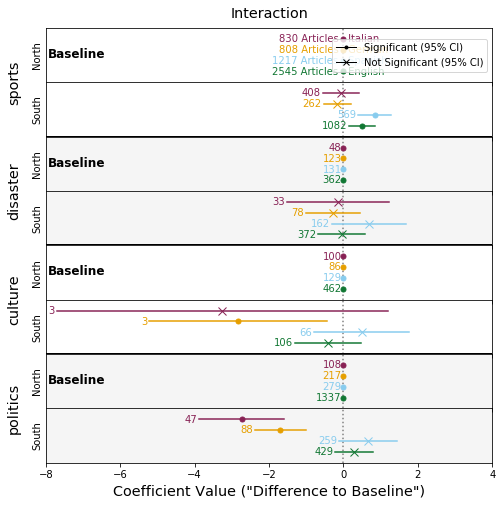

In [84]:
figres = plot_regression_results_interactions_from_dict(
    df_reg, fit_income, 
    ['cat:economic_region'], 
    include_counts=True, figsize=(8, 8), x_limits=(-8,4), title=f'Interaction')

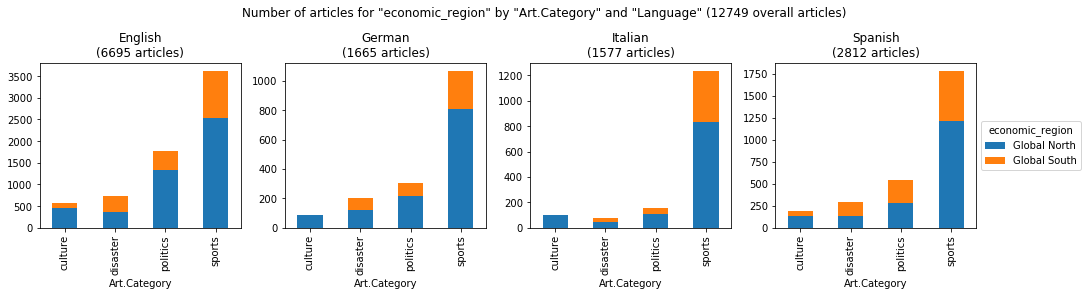

In [88]:
plot_cat_by_cat_variable(df_reg, col_plot='code', col_x='cat', col_bar='economic_region', stacked=True, sharey=False)

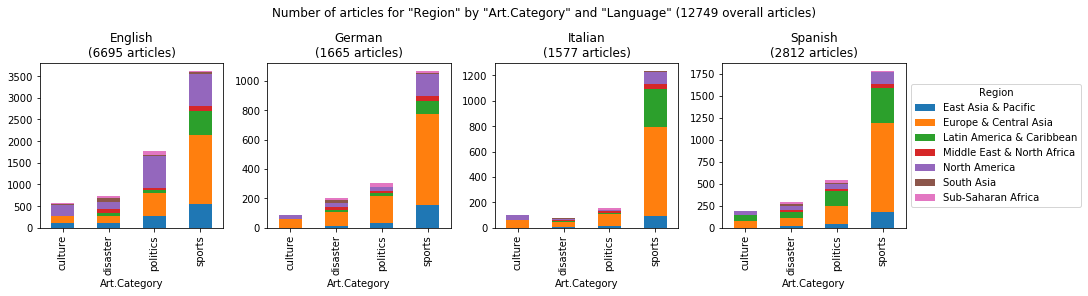

In [90]:
plot_cat_by_cat_variable(df_reg, col_plot='code', col_x='cat', col_bar='gni_region', stacked=True, sharey=False)